# Almgren-Chriss Optimal Execution - Dynamic Programming

## Syllabus

1. Model
2. Implementation

## 1. Model

What are the justifications for using dynamic programming to solve the Almgren-Chriss framework? According to D. Silver [5], dynamic programming can be used in problems that satisfy the following 2 properties:

- **Optimal substructure**: the optimal solution can be broken down into subproblems.
- **Overlapping subproblems**: subproblems recur multiple times and the solutions can be stored and reused.
	
One field dynamic programming can be used for is the solving of Markov decision processes (MDP), which is for a given set of states, a Markov chain with rewards (gain, loss) for each potential state and action (compared to the simple Markov chain, the agent in this setting has more control over his decision making). More importantly, the MDP has a state-value function and a action-value function which both respectively tell how is it to be in a particular state and to take a particular action (this state value function is known as the Bellman equation). Dynamic programming will look to find best policy (i.e. a set of actions to take), 
	
This effectively applies for the Almgren-Chriss optimal execution framework, which can be modelled as a Markov decision process: both optimal substructure (the objective of optimal liquidation at the lowest cost can be broken down into multiple trading periods) and overlapping sub-problems are applicable here (the same issues of portfolio liquidation recur for each trading period and a value function can evaluate how well the liquidation is going). We also know that the Almgren-Chriss by definition terminates (no issue of infinite MDPs) and the final rewards (i.e. the cost of liquidation) are known at the end. This makes dynamic programming a suitable technique for solving Almgren-Chriss.
	
*Note: compared to reinforcement learning algorithms (ex. temporal difference and Monte Carlo methods) which are model-free, dynamic programming assumes that the agent has full knowledge of the MDP, and thus can be used for finding the best policy (control problem).*
	
Now that we have managed to justify the use of dynamic programming with the Almgren-Chriss framework, how do we translate this into a model that can be implemented? The core principle of this approach is first to transition from the mean-variance problem (used in nonlinear programming) into the Bellman equation (used in dynamic programming). Consider that the market impact benchmark $X_B$ is a Gaussian random variable. If we still use the CARA utility function, we have:
	
$$ \mathbb{E}(e^{\gamma X_B}) = e^{\gamma \mathbb{E}(X_B) + \frac{\gamma^2}{2} \mathbb{V}(X_B)} $$
	
which as we previously showed can be transformed into
	
$$ \min_n \, \mathbb{E}(X_B) + \lambda \mathbb{V}(X_B) $$
	
Since the minimization of the CARA utility function is equivalent to the minimization of an expectation, we can consider that the Almgren-Chriss framework can be also be reformulated as the minimization of an expectation:
	
$$ \min_n \mathbb{E}(e^{-\gamma X_B}) = \min_n \mathbb{E}(e^{-\gamma X S_0 -\gamma \sum_{i=1}^N n_i \tilde{S}_i}) = \min_n \mathbb{E}(e^{-\gamma \sum_{i=1}^N n_i \tilde{S}_i}) $$
	
Let's consider $s$ as the stock price, $x$ as the inventory, $r$ the revenue of the liquidation and $t$ the time step, the Almgren-Chriss problem thus leads to the following Bellman equation:
	
- **Terminal condition**
	
	$$ v(r,x,s,T-1) = e^{-\gamma \big[r + x\big(s-g(\frac{x}{\tau})\big)\big]} $$
	
- **Backwards equation**
	
$$ v(r,x,s,t) = \min_n \, \mathbb{E}(v^*,x^*,s^*, t+1) $$
	
$$ r^* = r + x\Big[s-g\Big(\frac{n}{\tau}\Big)\Big] $$
	
$$ s^* = s + \sigma \zeta \sqrt{\tau} - \tau h\Big(\frac{n}{\tau}\Big) $$
	
$$ x^* = x - n $$
	
Implementing this Bellman equation however is fraught with difficulties. Since stock prices $s$ can take many different values, so thus the revenue $r$ and inventory $x$. Any combination $(x,t)$ (which can be modelled as a 2$\times$2 matrix) can take any value for the stock price $s$. Similarly the tensor $(x,t,s)$ can take any possible value for the revenue $r$, thus creating a tensor $(x,t,s,r)$. Thus, the previous implementation suffers from the curse of dimensionality, and solving Almgren-Chriss with these sets of equations will become a computational nightmare (especially since our updates are synchronous and do full sweeps).
	
The first solution to the curse of dimensionality is to approximate the value function $v(.)$ with methods such as reinforcement learning (ex. Q-Learning). Another approach (specific to implementation shortfall) is to simplify directly $v(x)$:
	
$$ v(r,x,s,t) = u(x,t) e^{-\gamma (r+xs)}$$
	
with $u(x,t)$ being a simplified value function that only depends on $x$ and $t$. We thus eliminated the variables $s$ and $r$ from the Bellman equation and reduced our value function matrix from a 4-dimensional tensor to a 2-dimensional matrix. We can know implement our dynamic programming principle on $u(t,x)$, instead of $v(r,x,s,t)$. Thus:
	
- **Terminal condition**
		
$$ u(x,T-1) = e^{\gamma x g \left(\frac{x}{\tau} \right)} $$
		
- **Backwards equation**

$$ u(x,t) = \min_{0<n<x} u(x-n,t+1) \, e^{\gamma n g \left(\frac{n}{\tau}\right) + \gamma (x-n) \tau h \left(\frac{n}{\tau}\right) + \frac{1}{2} \gamma^2 (x-n)^2 \sigma^2 \tau } $$
	
Note: this change of variable relies on the assumption that $r+xs$ is the mark-to-market valuation of our portfolio at any time $t$ during the entire liquidation process.


## 2. Implementation

### 2.1. Market impact functions

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

- Temporary market impact:

$$ h(x) = \eta \, x^{\alpha} $$

- *Permanent market impact*:

$$ g(x) = \gamma \, v^{\beta} $$

- *Hamiltonian*

$$ H(x,n) = \psi n g \left(\frac{n}{\tau}\right) + \psi (x-n) \tau h \left(\frac{n}{\tau}\right) + \frac{1}{2} \psi^2 (x-n)^2 \sigma^2 \tau $$

In [2]:
# Utilities
def h(x, alpha, eta):
    return eta * x ** (alpha)

def g(x, beta, gamma):
    return gamma * x ** (beta)

def H(x,n,psi,alpha,beta,gamma,eta,sigma=0.3,tau=0.5):
    """
    Hamiltonian equation. To be minimized through dynamic programming.
    """
    res = psi*n*g(n/tau,beta,gamma) + psi*(x-n)*tau*h(n/tau,alpha,eta) + 0.5*(psi**2)*(sigma**2)*tau*((x-n)**2)
    return res

### 2.2. Dynamic programming: a simplified version

Bellman equation with change of variable (made in our to solve the curse of dimensionality):

- **Terminal condition**

$$ u(x,T-1) = \exp \left[\psi x g \left(\frac{x}{\tau} \right) \right] $$

- **Backward induction**

$$ u(x,t) = \min_{0<n<x} u(x-n,t+1) \, \exp \left[\psi n g \left(\frac{n}{\tau}\right) + \psi (x-n) \tau h \left(\frac{n}{\tau}\right) + \frac{1}{2} \psi^2 (x-n)^2 \sigma^2 \tau \right] $$

where $\psi$ the risk aversion coefficient associated with the CARA utility function (this is no avoid confusions with the $gamma$ paramter found in the permanent impact function).

Python implementation:

In [3]:
def dynamic_programming(nb_T, X_total, psi, alpha, beta, gamma, eta, plot='True'):
    
    """
    MODEL
    - Bellman equation and value iteration for solving the Markov
      Decision Process of the Almgren-Chriss model.
    
    INPUTS
    - nb_T,       number of time steps
    - X_total,    number of shares to be liquidated
    - psi,        risk aversion
    """
    
    ### Initialization
    u = np.zeros(shape=(nb_T, X_total+1), dtype="float64")      # value function
    b = np.zeros(shape=(nb_T, X_total+1), dtype="int")          # best move
    inventoryforX = np.zeros(shape=(nb_T,1), dtype="int")       # evolution of inventory
    inventoryforX[0] = X_total
    N = []                                                      # optimal selling trajectory
    tau = 0.5
    
    ### Market microstructure: volatility, correlation
    ### [insert dynamic volatility data]
    
    ### Terminal condition
    for x in range(X_total+1):
        u[nb_T - 1, x] = np.exp(x * h(x/tau, alpha, eta))
        b[nb_T - 1, x] = x
    
    ### Backwards induction
    for t in range(nb_T-2, -1, -1):
        for x in range(X_total+1):
            
            best_value = u[t+1,0] * np.exp(H(x, x, psi, alpha, beta, gamma, eta))
            best_n = x
            
            for n in range(x):
                # We compute the utility function if we sell n shares
                current_value = u[t+1,x-n] * np.exp(H(x, n, psi, alpha, beta, gamma, eta))
                
                if current_value < best_value:
                    best_value = current_value
                    best_n = n   # nb of shares to liquidate
               
            u[t,x] = best_value
            b[t,x] = best_n
    
    ### Optimal trajectory
    for t in range(1, nb_T):
        inventoryforX[t] = inventoryforX[t-1] - b[t,inventoryforX[t-1]]
        N.append(b[t,inventoryforX[t-1]])
    
    N = np.asarray(N)
    
    ### Plot results
    if plot=='True':
        plt.figure(figsize=(7,5))
        plt.plot(inventoryforX, color='blue', lw=1.5)
        plt.xlabel('Trading periods')
        plt.ylabel('Number of shares')
        plt.grid(True)
        plt.show()
    
    return u, b, inventoryforX, N

## 3. Tests

- $T$, number of trading periods
- $X$, inventory to be liquidated
- $\psi$, risk aversion coefficient
- $\alpha$, power of temporary impact
- $\beta$, power of permanent impact
- $\gamma$, magnitude of permanent impact
- $\eta$, magnitude of temporary impact

Let's do a series of hyperparameter tests:

### 3.1. Initial tests

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp


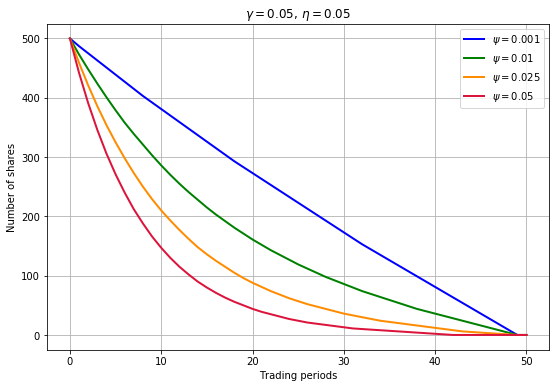

In [4]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.001, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.01, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.025, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.05, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.01$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.05$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.05$, $\eta=0.05$')
plt.grid(True)
plt.savefig('DP1.png')
plt.show()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars


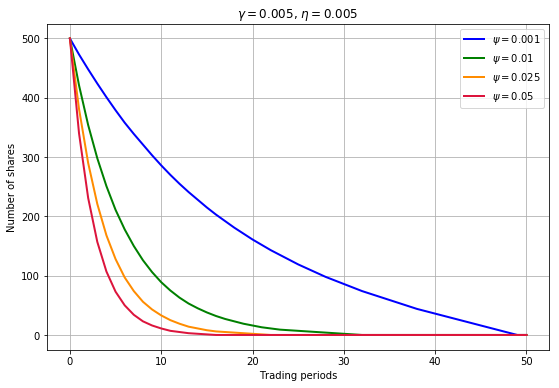

In [5]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.001, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.01, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.025, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.05, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.01$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.05$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.005$, $\eta=0.005$')
plt.grid(True)
plt.savefig('DP2.png')
plt.show()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars


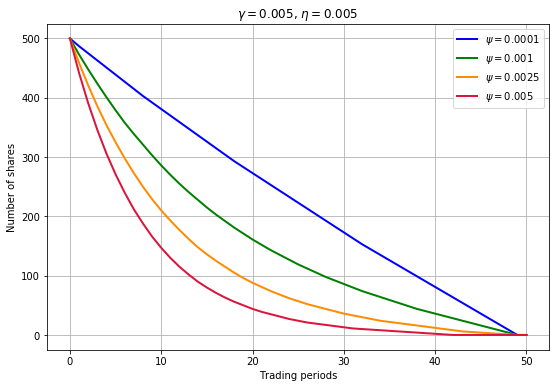

In [6]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.0001, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.001, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.0025, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.005, alpha=1, beta=1, gamma=0.005, eta=0.005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.0001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.0025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.005$, $\eta=0.005$')
plt.grid(True)
plt.savefig('DP3.png')
plt.show()

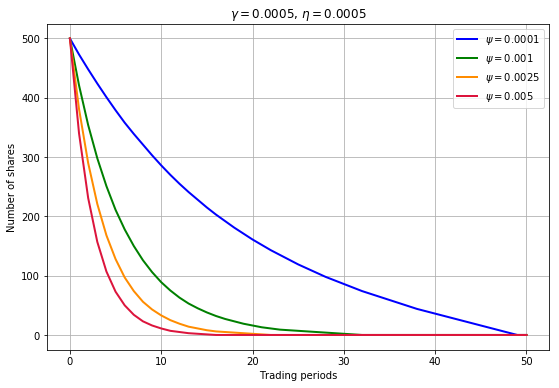

In [7]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.0001, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.001, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.0025, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.005, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.0001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.0025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.0005$, $\eta=0.0005$')
plt.grid(True)
plt.savefig('DP4.png')
plt.show()

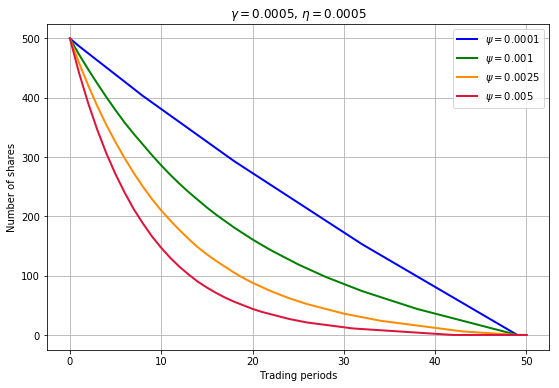

In [8]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.00001, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.0001, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.00025, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.0005, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.0001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.0025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.0005$, $\eta=0.0005$')
plt.grid(True)
plt.savefig('DP5.png')
plt.show()

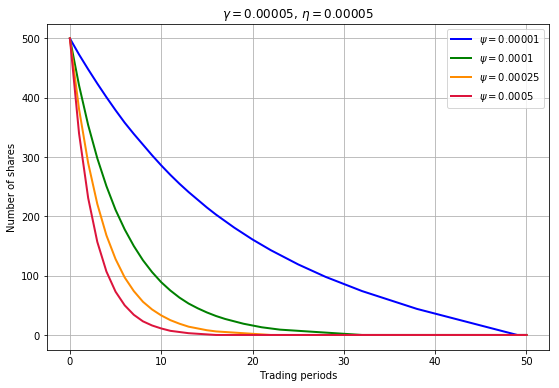

In [9]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.00001, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.0001, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.00025, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.0005, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.00001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.0001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.00025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.0005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.00005$, $\eta=0.00005$')
plt.grid(True)
plt.savefig('DP6.png')
plt.show()

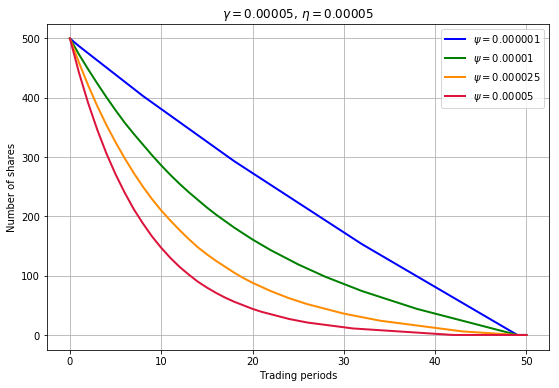

In [10]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.000001, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.00001, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.00005, alpha=1, beta=1, gamma=0.00005, eta=0.00005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.000001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.00001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.000025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.00005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.00005$, $\eta=0.00005$')
plt.grid(True)
plt.savefig('DP7.png')
plt.show()

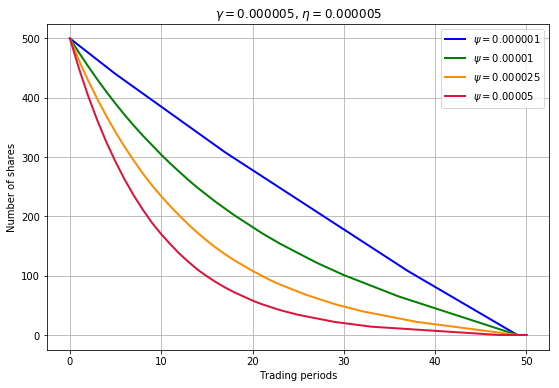

In [11]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.000001, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.00001, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.00005, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.000001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.00001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.000025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.00005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.000005$, $\eta=0.000005$')
plt.grid(True)
plt.savefig('DP8.png')
plt.show()

### 3.2. Comparing dynamic programming to nonlinear programming

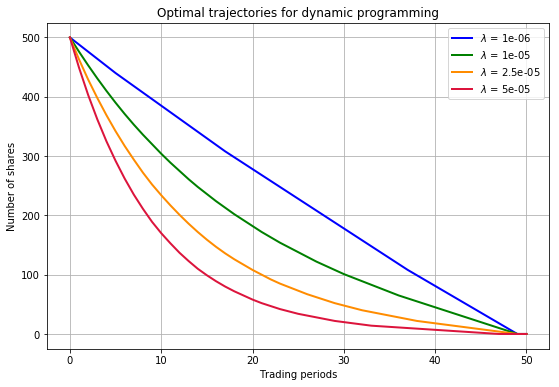

In [57]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.000001, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.00001, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.00005, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')

plt.figure(figsize=(9,6))

risks = [0.000001, 0.00001, 0.000025, 0.00005]

plt.plot(p1, color='blue', lw=2, label='$\lambda$ = '+str(risks[0]))
plt.plot(p2, color='green', lw=2, label='$\lambda$ = '+str(risks[1]))
plt.plot(p3, color='darkorange', lw=2, label='$\lambda$ = '+str(risks[2]))
plt.plot(p4, color='crimson', lw=2, label='$\lambda$ = '+str(risks[3]))

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
#plt.title('$\gamma=0.000005$, $\eta=0.000005$')
plt.grid(True)
plt.title('Optimal trajectories for dynamic programming')
plt.savefig('COMPARAISON_1')
plt.show()

In [13]:
def expectation_IS(N):
    """
    Expectation of implementation shortfall.
    """
    exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma)/tau * np.sum(N**2)
    return exp

def variance_IS(N, sigma=0.3):
    """
    Variance of implementation shortfall.
    """
    var = 0
    t = - 1
    while t < len(N) - 1:
        t = t + 1
        temp = (X - np.sum(N[0:t])) ** 2
        var = var + temp
    var = tau * (sigma**2) * var
    return var

In [24]:
gamma=2.5*10**(-7)
eta=2.5*10**(-6)
eps=0.0625
X=500
tau=0.5

print('Model 1')
print(expectation_IS(N1))
print(variance_IS(N1))

print('\nModel 2')
print(expectation_IS(N2))
print(variance_IS(N2))

print('\n\nModel 3')
print(expectation_IS(N3))
print(variance_IS(N3))

print('\nModel 4')
print(expectation_IS(N4))
print(variance_IS(N4))

Model 1
31.305684
175787.82

Model 2
31.3127805
114790.275


Model 3
31.3267835
79276.365

Model 4
31.345204
58022.19


Let's compare this to the nonlinear programming approach:

In [27]:
from scipy.optimize import minimize

def efficient_frontier_IS(X, risk, nb_T, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    
    def expectation_IS(N):
        """
        Expectation of implementation shortfall.
        """
        exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma)/tau * np.sum(N**2)
        return exp

    def variance_IS(N, sigma=0.3):
        """
        Variance of implementation shortfall.
        """
        var = 0
        t = - 1
        while t < len(N) - 1:
            t = t + 1
            temp = (X - np.sum(N[0:t])) ** 2
            var = var + temp
        var = tau * (sigma**2) * var
        return var
    
    def objective_IS(N):
        """
        Objective function for implementation shortfall.
        """
        obj = expectation_IS(N) + risk * variance_IS(N)
        return obj
    
    def optimization():
        """
        Optimal execution with optimization for implementation shortfall.
        """
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
        N = np.array(opt.x)
        return N
    
    N_opt = optimization()
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        """
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt, expectation_IS(N_opt), variance_IS(N_opt)
    
    return res

Efficient frontier:

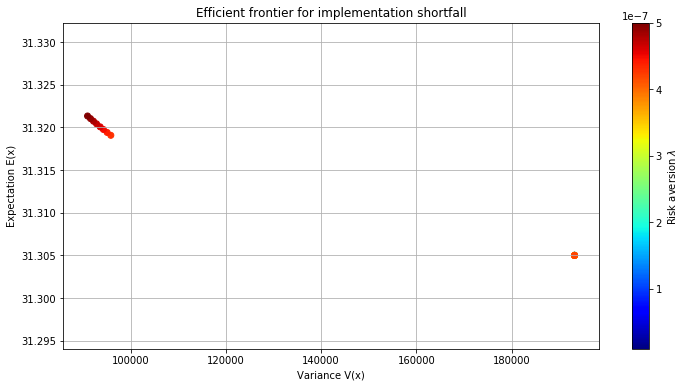

In [44]:
risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 50)

x_IS = []
y_IS = []

for r in risks:
    temp = efficient_frontier_IS(X=500, risk=r, nb_T=50,
                                 tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                 eps=0.0625, plot='False')
    
    x_IS.append(temp[2])  # V(x)
    y_IS.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(x_IS, y_IS, marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier for implementation shortfall')
plt.colorbar(label='Risk aversion $\lambda$')
plt.legend(loc='best')
plt.savefig('efficient_frontier_IS_comp.png')
plt.show()

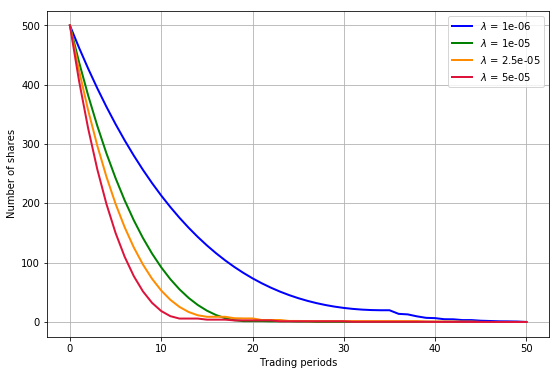

In [58]:
#risks = [-1*10**(-5), 0.0, 0.2*10**(-6), 1.0*10**(-6), 9.0*10**(-6)]
risks = [0.000001, 0.00001, 0.000025, 0.00005]

N_opts = []

for r in risks:
    temp = efficient_frontier_IS(X=500, risk=r, nb_T=50,
                                 tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                 eps=0.0625, plot='False')
    
    N_opts.append(temp[0])


# Plotting
plt.figure(figsize=(9,6))
plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
plt.plot(N_opts[2], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[2]))
plt.plot(N_opts[3], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[3]))

plt.grid(True)
plt.savefig('Optimal trajectories for nonlinear programming')
plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.savefig('COMPARAISON_2.png')
plt.show()

### 3.3. The sensitivity to invetory size $X$

This might be something to consider but if we increase the inventory to $X=1000$, we get completly different plots:

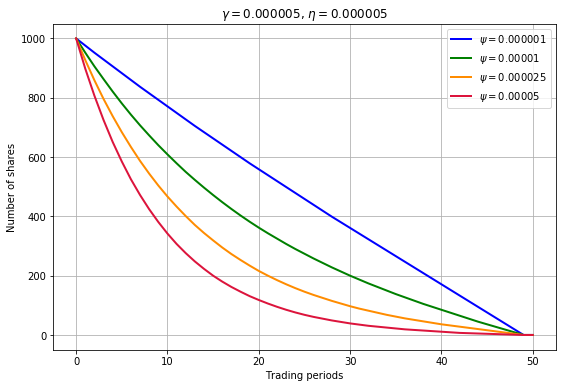

In [59]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=1000, psi=0.000001, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=1000, psi=0.00001, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=1000, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=1000, psi=0.00005, alpha=1, beta=1, gamma=0.00005, eta=0.000005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.000001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.00001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.000025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.00005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.000005$, $\eta=0.000005$')
plt.grid(True)
plt.savefig('DP_X1.png')
plt.show()

But if we go back to our initial market impact coefficients:

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp


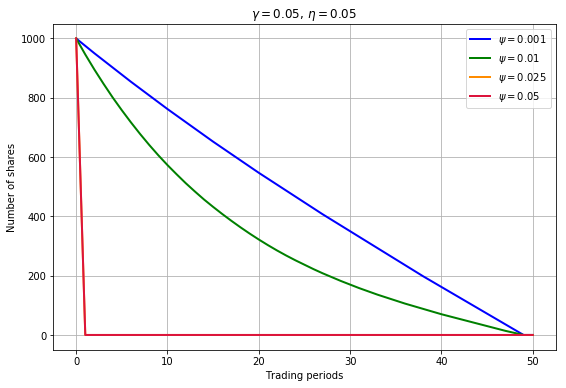

In [47]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=1000, psi=0.001, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=1000, psi=0.01, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=1000, psi=0.025, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=1000, psi=0.05, alpha=1, beta=1, gamma=0.05, eta=0.05, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.01$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.05$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.05$, $\eta=0.05$')
plt.grid(True)
plt.savefig('DP_X2.png')
plt.show()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars


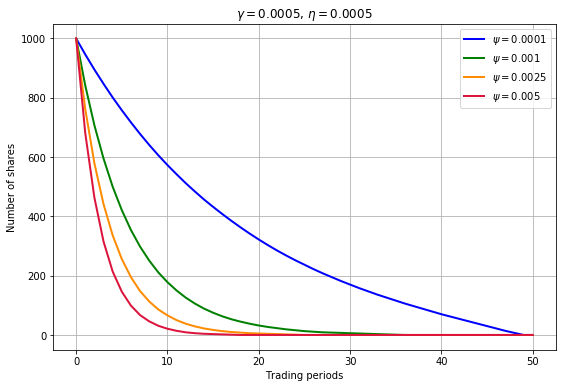

In [48]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=1000, psi=0.0001, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=1000, psi=0.001, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=1000, psi=0.0025, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=1000, psi=0.005, alpha=1, beta=1, gamma=0.0005, eta=0.0005, plot='False')

plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=2, label='$\psi=0.0001$')
plt.plot(p2, color='green', lw=2, label='$\psi=0.001$')
plt.plot(p3, color='darkorange', lw=2, label='$\psi=0.0025$')
plt.plot(p4, color='crimson', lw=2, label='$\psi=0.005$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.title('$\gamma=0.0005$, $\eta=0.0005$')
plt.grid(True)
plt.savefig('DP_X3.png')
plt.show()